___

**project**: `Symptoms to Disease Classifier (S2DC)`

**date**: `2023-04-13`

**decription`**: `In this notebook I'm going to create a simple AI classification model using NLP techniquies that will accurately identify the disease based on the description of the symptoms.`

**main**: `Natural Language Processing (NLP) pytorch`

**programmer**: `crispengari`

**architecture**: `BiDirectional Long Short Term Memory [BiLSTM] (torchtext)`

**language:** `python`

____


### Problem Statement
"Most people have certain symptoms and they fail to indentify wether they are sick or not. Sometimes others even ignore the symptoms because they lack knowledge. Using Deep Learning techniquies we want to implement an AI tool that will be able to identify the possible disease based on description of the symptoms by someone who's feeling sick."

In this project I will create a simple classifiation model that will be able to classify the `disease` based on symptoms from text.

### Data
The dataset that we going to use in this notebook we be comming from [kaggle](https://www.kaggle.com/datasets/niyarrbarman/symptom2disease).

### Model Architecture
We are going to use `BiLSTM` in doing `multi-class` classifications of diseases based on the textual description that we are going to get from anyone using the model. We are going to use the following notebook as reference:

> [10_MENTAL_HEALTH_CONVERSATION_BOT](https://github.com/CrispenGari/nlp-pytorch/blob/main/10_MENTAL_HEALTH_CONVERSATION_BOT/01_MENTAL_HEALTH_CONVERSATION_BOT.ipynb)

### Installing Helper Packages
In the following code cell we are going to install the package called `helperfns` that provide us with some usefull helper functions for machine learning.

In [1]:
pip install helperfns -q

#### Imports

In  the following code cell we are going to import all the packages that we are going to use throughout this `notebook`

In [2]:
import time
import json
import torch
import os
import random
import torchtext
from matplotlib import pyplot as plt
from torch import nn
from torchtext import data
from collections import Counter
from torchtext import vocab

from helperfns.tables import tabulate_data
from helperfns.visualization import plot_complicated_confusion_matrix, plot_simple_confusion_matrix, plot_classification_report
from helperfns.utils import hms_string

import torch.nn.functional as F
import numpy as np
import pandas as pd

from google.colab import drive, files

torchtext.__version__, torch.__version__

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


('0.16.0+cpu', '2.1.0+cu121')

### Seed
In the following code cell we are going to set the seed to all random operations for reproducivity.

In [3]:
SEED = 42

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True

### Device
In the following code cell we are going to get `gpu` device if possible

In [4]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Data

Our dataset that we are going to use will be comming from [`kaggle`](https://www.kaggle.com/datasets/niyarrbarman/symptom2disease) and will be loaded from google drive  where i uploaded it in a folder called `S2DC`. So in the following code cell we are going to mount our google drive to this colab instance.

In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


### Path to the dataset.
Now we can define the path as a variable to the location where our dataset file called `Symptom2Disease.csv` is located.

In [6]:
base_dir = "/content/drive/My Drive/NLP Data/S2DC"

assert os.path.exists(base_dir), f"The path '{base_dir}' does not exists."

data_path = os.path.join(base_dir, 'Symptom2Disease.csv')

assert os.path.exists(data_path), f"The path '{data_path}' does not exists."

Then we need to read the `Symptom2Disease.csv` file and create a classification dataset from it. For that we are going to use pandas and read the giant file into a dataframe as follows:

In [7]:
dataframe = pd.read_csv(data_path)
dataframe.head(2)

,Unnamed: 0,label,text
0,0,Psoriasis,I have been experiencing a skin rash on my arm...
1,1,Psoriasis,"My skin has been peeling, especially on my kne..."


In this dataframe we only care about two field which are `label` and `text`. First let's check the classes or unique labels that we are going to have in this dataset.

In [8]:
diseases = dataframe.label.unique()
diseases, len(diseases)

(array(['Psoriasis', 'Varicose Veins', 'Typhoid', 'Chicken pox',
        'Impetigo', 'Dengue', 'Fungal infection', 'Common Cold',
        'Pneumonia', 'Dimorphic Hemorrhoids', 'Arthritis', 'Acne',
        'Bronchial Asthma', 'Hypertension', 'Migraine',
        'Cervical spondylosis', 'Jaundice', 'Malaria',
        'urinary tract infection', 'allergy',
        'gastroesophageal reflux disease', 'drug reaction',
        'peptic ulcer disease', 'diabetes'], dtype=object),
 24)

So we have `24` different kind of diseases that can be classified, based on the user text. In the following code cell we are going to extract `features` and `labels` from this giant dataframe so that we can create, different sets from it.

In [9]:
labels, features = [label.lower() for label in dataframe.label.values], [feature.lower() for feature in dataframe.text.values]

labels[:2], features[:2]

(['psoriasis', 'psoriasis'],
 ['i have been experiencing a skin rash on my arms, legs, and torso for the past few weeks. it is red, itchy, and covered in dry, scaly patches.',
  'my skin has been peeling, especially on my knees, elbows, and scalp. this peeling is often accompanied by a burning or stinging sensation.'])

Now that we have converted all features and labels into list of values with common case we can create a giant dataset from this in the following code cell.

In [10]:
dataset = list()
for feature, label in zip(features, labels):
   dataset.append((feature, label))
print("Dataset size: {}".format(len(dataset)))

Dataset size: 1200


We have a small dataset that contains `1200` examples, let's check the first `10` examples in the dataset:

In [11]:
dataset[:10]

[('i have been experiencing a skin rash on my arms, legs, and torso for the past few weeks. it is red, itchy, and covered in dry, scaly patches.',
  'psoriasis'),
 ('my skin has been peeling, especially on my knees, elbows, and scalp. this peeling is often accompanied by a burning or stinging sensation.',
  'psoriasis'),
 ('i have been experiencing joint pain in my fingers, wrists, and knees. the pain is often achy and throbbing, and it gets worse when i move my joints.',
  'psoriasis'),
 ('there is a silver like dusting on my skin, especially on my lower back and scalp. this dusting is made up of small scales that flake off easily when i scratch them.',
  'psoriasis'),
 ('my nails have small dents or pits in them, and they often feel inflammatory and tender to the touch. even there are minor rashes on my arms.',
  'psoriasis'),
 ('the skin on my palms and soles is thickened and has deep cracks. these cracks are painful and bleed easily.',
  'psoriasis'),
 ('the skin around my mouth, n

Next we are going to use the `random` module to shuffle our dataset and then check again the size first `10` examples before creating dataframes.

In [12]:
random.shuffle(dataset)

In [13]:
dataset[:10]

[("i've recently been suffering with chills, lethargy, a cough, a high temperature, and difficulties breathing. i've been sweating profusely and generally feeling ill and weak. i've also had some quite thick and red phlegm.",
  'pneumonia'),
 ('i have been having severe itching, vomiting, and fatigue. i have also lost weight and have a high fever. my skin has turned yellow and my urine is dark. i am also experiencing abdominal pain.',
  'jaundice'),
 ("i'm having a lot of trouble with my bowel movements lately. it's hard to go and it hurts when i do. my anus is really sore and it's been bleeding when i go. it's really painful and i'm really uncomfortable.",
  'dimorphic hemorrhoids'),
 ("i can't seem to catch my breath and i'm sweating a lot. i feel really sick and have a lot of phlegm in my throat. my chest hurts and my heart is racing. the mucus i'm coughing up is brownish and stringy.",
  'pneumonia'),
 ("along with a phlegmy cough and muscle weakness, i've been dealing with excruci

So for our train data we are going to take all the examples in the `dataset` and then for the `validation` and `testing` set we are going to take a fraction of `40%` and `60%` from the dataset respectively.

In [14]:
train_df = pd.DataFrame(dataset, columns=["text", "label" ])

TEST_EXAMPLES = int(.4 * len(dataset))

random.shuffle(dataset)
test_df = pd.DataFrame(dataset[:TEST_EXAMPLES], columns=["text", "label" ])
val_df = pd.DataFrame(dataset[TEST_EXAMPLES: ], columns=["text", "label" ])

Checking our dataframes.


1. train dataframe

In [15]:
train_df.head(5)

,text,label
0,"i've recently been suffering with chills, leth...",pneumonia
1,"i have been having severe itching, vomiting, a...",jaundice
2,i'm having a lot of trouble with my bowel move...,dimorphic hemorrhoids
3,i can't seem to catch my breath and i'm sweati...,pneumonia
4,along with a phlegmy cough and muscle weakness...,cervical spondylosis


2. test dataframe

In [16]:
test_df.head(5)

,text,label
0,i have a plugged nose and nasal congestion. i ...,allergy
1,the itching is making it hard for me to sleep ...,chicken pox
2,"recently, my calves have been cramping up freq...",varicose veins
3,"i've had back pain, a persistent cough, and we...",cervical spondylosis
4,i have pain near my pelvic region and vomit a ...,urinary tract infection


3. validatation dataframe

In [17]:
val_df.head(5)

,text,label
0,"i've been feeling scratchy, sick, and worn out...",jaundice
1,"i feel tired all the time, i have lost my tast...",allergy
2,"i have been experiencing intense itching, vomi...",jaundice
3,i've been having trouble going to the bathroom...,dimorphic hemorrhoids
4,i feel tired every day. there are red spots al...,chicken pox


Now that we have text matched to labels, we can go ahead and save the `csv` files for these 3 different sets of data

In [18]:
train_df.to_csv(os.path.join(base_dir, "train.csv"),  index = False, header = True)
test_df.to_csv(os.path.join(base_dir, "test.csv"),  index = False, header = True)
val_df.to_csv(os.path.join(base_dir, "val.csv"),  index = False, header = True)
print("Done")

Done


In the following code cell we are going to count the examples that are in each set of our whole dataset.

In [19]:
columns = ["Set", "Example(s)"]

examples = [
    ['training', len(train_df)],
    ['validation', len(val_df)],
    ['testing', len(test_df)],
    ['total', len(train_df) +  len(test_df) + len(val_df)],
]

tabulate_data(columns, examples, "Exmples")

Exmples
+------------+------------+
| Set        | Example(s) |
+------------+------------+
| training   |       1200 |
| validation |        720 |
| testing    |        480 |
| total      |       2400 |
+------------+------------+


The following visualization shows how the fraction of each example in each set.

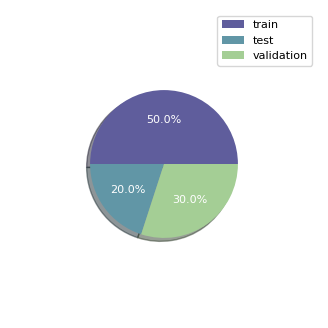

In [20]:
plt.figure(figsize=(4, 4))
plt.pie([len(train_df), len(test_df), len(val_df)], explode= [.0, .0, .0], labels=['train', 'test', 'validation'],
        colors=['#5F5D9C', '#6196A6', '#A4CE95'],
        pctdistance=0.6, shadow=True, autopct='%1.1f%%', textprops={'color': 'white', 'fontsize':8}, radius=.6)
plt.legend(fontsize=8)
plt.show()

### Features and Labels
Our fetures are the actual `text` in the dataframes which is the column named `text` and our labels will come from the column called `label`. In the following code cell we are going to read features and labels in a numpy arrays for each set.

In [21]:
# train
train_texts = train_df.text.values
train_labels = train_df.label.values

# test
test_texts = test_df.text.values
test_labels = test_df.label.values

# val
val_texts = val_df.text.values
val_labels = val_df.label.values

### Text Preprocessing
In our text processing pipeline we need to do the following steps:

1. tokenize sentences
* this is the process of converting a sentence or text into senquence of word. For this process we are going to use a pre-trained model from spacy language model. You can read more about other tokenizers that you can use at [pytorch](https://pytorch.org/text/stable/data_utils.html).org.

2. vocabulary
We will to create a vocabulary based on our sentences that are in the train dataset. A `vocabulary` is esentially a `word` to `index` mapping that allows us to reference the word with their integer representation, since machine leaning models does not understand words. This vocabulary will be used during model training and also can be used at model inference.

### Tokenizer
In the following code cell we are going to geta a tokenier object that will convert a sentence into a sequence of word using the `spacy-en` language model. The reason we are using the english langauge model it's because our intents are in english.

In [22]:
tokenizer = data.utils.get_tokenizer('spacy', 'en')
tokenizer("This is a boy.")

/usr/local/lib/python3.10/dist-packages/torchtext/data/utils.py:105: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(


['This', 'is', 'a', 'boy', '.']

### Vocabulary
In the following code cell we are going to create a `vocabulary` object from torchtext. So we are going to use the `Counter` module from `collections` to generate these counts from our train features.

We are going to specify the `min_freq` to `2` meaning that the words that does not appear at least 2 times will be converted to unknown. We are also going to specify the special tokens during creation of the vocabulary object.

In [23]:
counter = Counter()
for line in train_texts:
    counter.update(tokenizer(line))
#  our special tokens are (unknown, padding, start of sentence, end of sentence)
vocabulary = vocab.vocab(counter, min_freq=2, specials=('<unk>', '<pad>', '<sos>', '<eos>'))

### STOI - String To Integer
This will be a dictionary that contains a string to integer mapping which will be our actual vocabulary. In the following code cell we are going to create object called `stoi` which is essentially a dictionary of word to index mapping. This dictionary will be used during training as well as during model inference.

In [24]:
stoi = vocabulary.get_stoi()

### Text Pipeline
After our text has been tokenized we need a way of converting those words into numbers because machine leaning models understand numbers not words. That's where we the `text_pipeline` function comes into play. So this function takes in a sentence and tokenize it then converts each word to a number. Note that the word that does not exists in the vocabulay (`stoi`) will be converted to  an unkown `('<unk>')` token (0).

In [25]:
def text_pipeline(x: str):
  values = list()
  tokens = tokenizer(x.lower()) # convert to lower case.
  for token in tokens:
    try:
      v = stoi[token]
    except KeyError as e:
      v = stoi['<unk>']
    values.append(v)
  return values

### Label pipeline
Our labels for now are just textual. We also need to convert these labels into numbers. This is very simple what we need to do is to get all the uniqe labels and then create a `labels_vocab` which is a label to integer representation.

> As you have noticed we have `24` labels which are diseases that we need to  predict given a sequence of words or symptoms description.

The `label_pipeline` function will then takes in the label and then returns us an integer representation of that label.

In [26]:
labels_dict = {k: v for v, k in enumerate([d.lower() for d in diseases])}

In [27]:
label_pipeline = lambda x: labels_dict[x]

Now that we have our vocabularies for labels `labels_dict` and  features `stoi` we can then save thes files as they will be used suring model inference. We are going to save these files as `.json` files.

In [28]:
with open(os.path.join(base_dir, "vocab.json"), 'w') as f:
  f.write(json.dumps(stoi, indent=2))

with open(os.path.join(base_dir, "labels_dict.json"), 'w') as f:
  f.write(json.dumps(labels_dict, indent=2))

print("Saved!!")

Saved!!


Let's visualize how the labels are distributed in each set. For that we are going to create a function called `get_x_y()` that allows us to get `x` values and `y` values. And these values we are going to use them to plot a `bar` graph.

In [29]:
def get_x_y(labels):
  d = {i: 0 for i in range(len(labels_dict))}
  for label in labels:
    v = labels_dict[label]
    d[v] += 1
  return d.keys(), d.values()

colors = np.array([
    '#86A789', '#B2C8BA', '#D2E3C8', '#EBF3E8', '#3A4D39',
    '#FF7F50', '#FFA07A', '#FFDAB9', '#FFE4C4', '#FFDEAD',
    '#6495ED', '#87CEEB', '#B0E0E6', '#ADD8E6', '#87CEFA',
    '#20B2AA', '#48D1CC', '#AFEEEE', '#00CED1', '#E0FFFF',
    '#FFD700', '#FFA500', '#FF8C00', '#FF6347'
])

### Training Labels Distribution
In teh following code cell we are going to visualize how the labels are distributed in the `train` set.

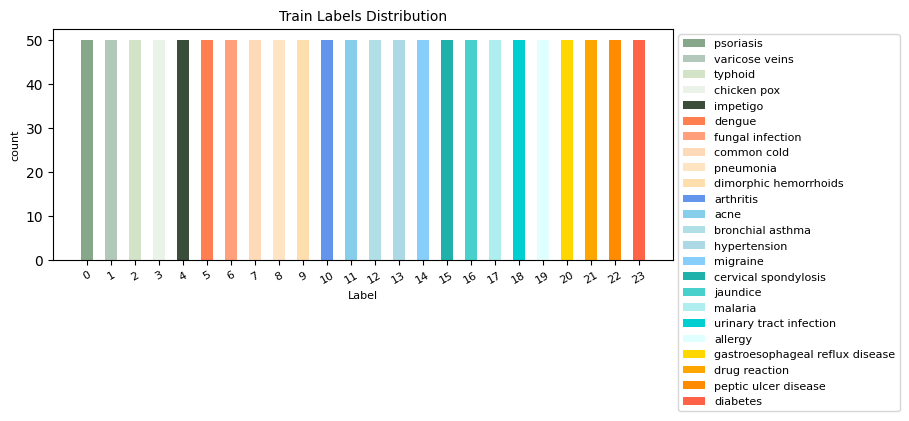

In [30]:
x, y = get_x_y(train_labels)
plt.figure(figsize=(8, 3))
plt.bar(x, y, color=colors, label=x,  width=.5)
plt.title('Train Labels Distribution', fontsize=10)
plt.xlabel("Label", fontsize=8)
plt.ylabel("count", fontsize=8)
plt.xticks(rotation=30, fontsize=8, ticks=list(labels_dict.values()))
plt.legend(fontsize=8, labels=list(labels_dict.keys()), bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

### Test Labels Distribution
In teh following code cell we are going to visualize how the labels are distributed in the `test` set.

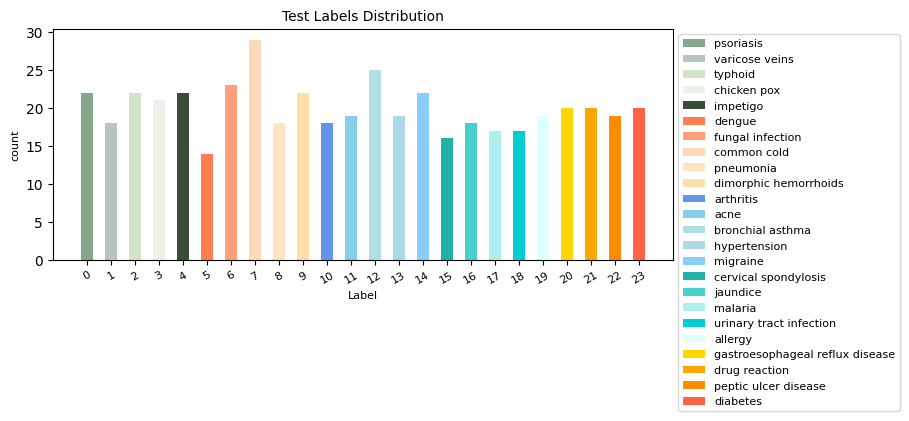

In [31]:
x, y = get_x_y(test_labels)
plt.figure(figsize=(8, 3))
plt.bar(x, y, color=colors, label=x,  width=.5)
plt.title('Test Labels Distribution', fontsize=10)
plt.xlabel("Label", fontsize=8)
plt.ylabel("count", fontsize=8)
plt.xticks(rotation=30, fontsize=8, ticks=list(labels_dict.values()))
plt.legend(fontsize=8, labels=list(labels_dict.keys()), bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

### Validation Labels Distribution
In teh following code cell we are going to visualize how the labels are distributed in the `validation` set.

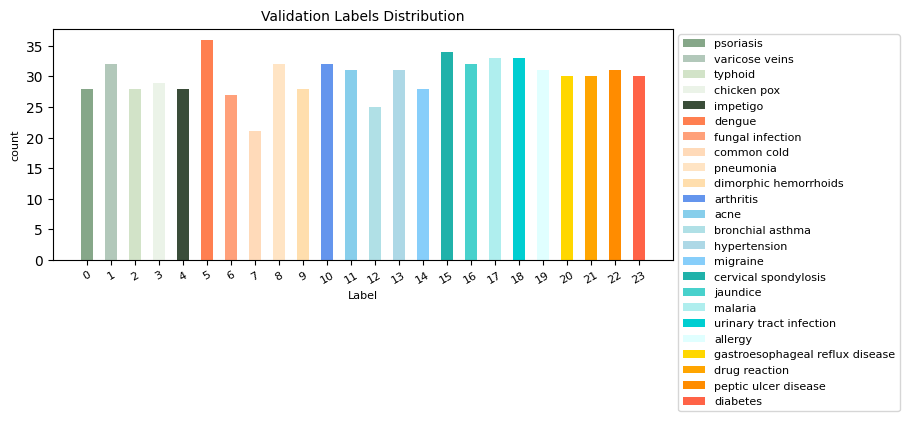

In [32]:
x, y = get_x_y(val_labels)
plt.figure(figsize=(8, 3))
plt.bar(x, y, color=colors, label=x,  width=.5)
plt.title('Validation Labels Distribution', fontsize=10)
plt.xlabel("Label", fontsize=8)
plt.ylabel("count", fontsize=8)
plt.xticks(rotation=30, fontsize=8, ticks=list(labels_dict.values()))
plt.legend(fontsize=8, labels=list(labels_dict.keys()), bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

### Pretrained vectors
In the following code cell we are going to download the predtrained word vectors. We are going to use the `GloVe.6B.100d`. These are pretrained vectors that were trained with about `~6B` words and have a vector representation of a word in `100` dimension for each word.

In [33]:
EMBEDDING_DIM = 100
glove_vectors = vocab.GloVe('6B', dim=EMBEDDING_DIM)

.vector_cache/glove.6B.zip: 862MB [02:53, 4.97MB/s]                           
100%|█████████▉| 399999/400000 [00:20<00:00, 19663.92it/s]


### Creating Embedding matrix
Now that we have our glove vectors we need to costomize them so that they fit our use case. We are going to create an embedding matrix that suits the our vocabulary. So essentially this embedding matrix will be the word to vector mapping for all the words that arein our vocabulary.

In [34]:
VOCAB_SIZE = len(stoi)
EMBEDDING_MATRIX= torch.zeros([VOCAB_SIZE, EMBEDDING_DIM])
for i, word in enumerate(vocabulary.get_itos()):
  EMBEDDING_MATRIX[i] = glove_vectors[word]

In the followig code cell we are going to check the embedding matrix for the word `"the"`.

In [35]:
EMBEDDING_MATRIX[stoi['rashes']]

tensor([-0.0940, -0.4780,  0.1963,  0.1708, -0.3933,  0.1521,  0.0457,  0.1012,
         0.1560, -0.7529, -0.4220, -0.7771,  0.9255,  0.4668,  0.7455, -0.0863,
        -0.9490, -0.9518,  0.1909, -0.6723, -0.5767,  0.6063, -0.7237,  0.8700,
         0.6882,  0.8048,  0.6606, -0.0345,  0.3939, -0.9757,  0.3382,  0.2372,
        -0.1619, -0.1441, -0.7168,  0.2400,  0.5837, -0.3739, -0.0716,  0.5532,
        -0.1439,  0.6237, -0.7219, -1.1488, -0.8956,  1.3508,  0.3170,  0.6591,
         0.2489, -0.3259, -0.2373, -0.2869, -0.8275,  0.2285,  0.3482,  0.0633,
         0.5941,  0.2802, -0.9896, -0.2571,  0.3315,  1.4114,  0.5243,  0.2785,
        -0.2324, -0.0899,  0.5105, -0.7090,  0.6590, -1.2017, -0.3753, -0.1030,
         0.4379, -0.0864, -0.0114,  0.9335, -0.3950,  0.5125, -0.0697,  0.8756,
         0.6625, -0.2473,  0.1869,  0.6091, -0.7198, -0.4607,  0.5697,  0.1913,
        -0.9225,  0.4444, -0.1880, -0.2680, -0.1879,  0.2891,  0.4514,  1.0086,
        -0.5549, -0.5044,  0.7773, -0.98

### Creating Dataset for Training

In the following code cell we are going to create a dataset class called `S2DCDataset`. This dataset will takes in the labels and the text of a set.

In [36]:
class S2DCDataset(torch.utils.data.Dataset):
  def __init__(self, labels, text):
    super(S2DCDataset, self).__init__()
    self.labels = labels
    self.text = text

  def __getitem__(self, index):
    return self.labels[index], self.text[index]

  def __len__(self):
    return len(self.labels)

### collate_fn
We are going to create a collate function called `tokenize_batch`. This function actually takes in a `batch` and does the preprocessing of the text and labels. This function will be passed to the `DataLoader` class to do the preprocessing of features and labels.

`tokenize_batch` function:

* this function takes in a batch in each set and convert the features and labels to integer representation. It goes ahead and `pad` and `truncate` the sequence to the same `length` and returns `labels` and `features`.

In [37]:
def tokenize_batch(batch, max_len=100, padding="pre"):
  assert padding=="pre" or padding=="post", "the padding can be either pre or post"
  labels_list, text_list = [], []
  for _label, _text in batch:
    labels_list.append(label_pipeline(_label))
    text_holder = torch.zeros(max_len, dtype=torch.int32)
    processed_text = torch.tensor(text_pipeline(_text.lower()), dtype=torch.int32)
    pos = min(max_len, len(processed_text))
    if padding == "pre":
      text_holder[:pos] = processed_text[:pos]
    else:
      text_holder[-pos:] = processed_text[-pos:]
    text_list.append(text_holder.unsqueeze(dim=0))
  #  the labels will be torch long tensors since it is a multi-class classification.
  return torch.LongTensor(labels_list), torch.cat(text_list, dim=0)

### Datasets
In the following code cell we are going to create the datasets for all our three sets using the `MHCBataset` class.

In [38]:
train_dataset = S2DCDataset(train_labels, train_texts)
test_dataset = S2DCDataset(test_labels, test_texts)
val_dataset = S2DCDataset(val_labels, val_texts)

### Iterators
In the following code cell we are going to create loaders using the `DataLoader` class from `torch.utils.data` for our `3` sets. We are going to use the `batch_size` of `128` and our `collate_function` is `tokenize_batch`. For the validation and testing dataset we are going to set the shuffle to `False` because there's no need fo us to shuffle these examples.

In [39]:
BATCH_SIZE = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=tokenize_batch)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=tokenize_batch)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=tokenize_batch)

Checking a single Batch Data

In [40]:
lbl, txt = next(iter(train_loader))

Labels in the first batch.

In [41]:
lbl

tensor([ 2,  0,  4, 10,  9,  5,  0,  4,  2, 22, 14, 16,  5, 22,  2,  0, 16, 13,
         6,  3,  5, 10, 11,  8, 13,  7, 14, 23, 10, 19, 16,  7, 22,  5,  2,  9,
        17,  3,  2,  5, 19,  9,  5,  4, 20, 14,  0, 14, 18, 13, 15, 12, 19,  6,
        22, 14,  0, 10, 14, 19, 21, 21, 16, 17,  4,  8,  4, 12, 13,  1, 21,  2,
        15, 16, 18, 22,  9,  0,  5,  0,  0, 17,  1, 16,  2, 12,  0,  8, 21,  6,
        12, 15, 14,  2,  8, 23,  4,  4,  1,  8, 10, 13, 22, 22,  4, 14,  8, 19,
        22, 23,  5, 15, 22, 17, 17, 22, 11, 17, 11,  1, 12, 14, 18, 11,  2,  3,
         4, 14])

The first sentence in the batch.

In [42]:
txt[0]

tensor([  4,  34,   7,  24,  71, 475,  17,  26,  11,  17,   4,  76,  77,  78,
         65, 189, 644,  57,  62,  20,   4,  34,  13, 336,  42,  17,  13, 678,
         54,  83,  43,  53, 503,  20,   4,  76,  77, 940, 297,  49, 916,  20,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0], dtype=torch.int32)

### Model Creation
Now that we have our loaders we can now create a model. The model that we are going to create is called `S2DCModel`.  As mentioned we are going to use `BiDirectional Long Short Term Memory (BiLSTM)` to build this model.

In [43]:
class S2DCModel(nn.Module):
  def __init__(self, vocab_size, embedding_size, hidden_size, output_size, num_layers
               , bidirectional, dropout, pad_idx):
    super(S2DCModel, self).__init__()

    self.embedding = nn.Sequential(
        nn.Embedding(vocab_size, embedding_dim=embedding_size, padding_idx=pad_idx),
        nn.Dropout(dropout)
    )
    self.lstm = nn.Sequential(
        nn.LSTM(
          embedding_size,
          hidden_size=hidden_size,
          bidirectional=bidirectional,
          num_layers=num_layers,
          dropout=dropout
        )
    )
    self.out = nn.Sequential(
        nn.Linear(hidden_size * 2, out_features=128),
        nn.Dropout(dropout),
        nn.Linear(128, out_features=output_size),
        nn.Dropout(dropout)
    )

  def forward(self, text, text_lengths):
    embedded = self.embedding(text)
    # set batch_first=true since input shape has batch_size first and text_lengths to the device.
    packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'), enforce_sorted=False, batch_first=True)
    packed_output, (h_0, c_0) = self.lstm(packed_embedded)
    output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
    output = torch.cat((h_0[-2,:,:], h_0[-1,:,:]), dim = 1)
    return self.out(output)

### Model Instance
In the following code cell we are going to create a model instance.

In [44]:
INPUT_DIM = len(stoi)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = len(labels_dict)
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = stoi['<pad>']
s2dc_model = S2DCModel(
              INPUT_DIM,
              EMBEDDING_DIM,
              HIDDEN_DIM,
              OUTPUT_DIM,
              N_LAYERS,
              BIDIRECTIONAL,
              DROPOUT,
              PAD_IDX
).to(device)
s2dc_model

S2DCModel(
  (embedding): Sequential(
    (0): Embedding(1127, 100, padding_idx=1)
    (1): Dropout(p=0.5, inplace=False)
  )
  (lstm): Sequential(
    (0): LSTM(100, 256, num_layers=2, dropout=0.5, bidirectional=True)
  )
  (out): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_features=128, out_features=24, bias=True)
    (3): Dropout(p=0.5, inplace=False)
  )
)

### Counting Model Parameters
In the following code cell we are going to count the model parameters.

In [45]:

def model_params(model):
  total_params = sum([p.numel() for p in model.parameters()])
  trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])
  tabulate_data(["","Parameters"],
           [["total parameters", f'{total_params:,}'],
            ["trainable parameters", f'{trainable_params:,}']],
           "MODEL PARAMETERS"
           )
model_params(s2dc_model)

MODEL PARAMETERS
+----------------------+------------+
|                      | Parameters |
+----------------------+------------+
| total parameters     |  2,491,604 |
| trainable parameters |  2,491,604 |
+----------------------+------------+


### Loading Embedding Vectors
In the following code cell we are going to load the pretained custom vectors in our embedding layer. We are going to load the embedding vectors tha suits our data using the `mhcb_model.embedding[0].weight.data.copy_(EMBEDDING_MATRIX)` as follows:

In [46]:
s2dc_model.embedding[0].weight.data.copy_(EMBEDDING_MATRIX)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.8353,  0.5702,  0.1922,  ..., -0.2583,  1.1413, -0.2057],
        [ 0.5105, -0.6065,  0.5856,  ...,  0.0143,  0.7046,  0.2131],
        [ 0.0220, -0.1008,  0.2294,  ..., -0.9317,  0.8893,  0.3623]],
       device='cuda:0')

### Optimizer and Criterion

In the following code cell we are going to define the `optimizer` and `criterion`. For the `optimizer` we are going to use the `Adam` optimizer with default parameters and for the criterion we are going to use the `CrossEntropyLoss()` function since this is a `multi-class` classification.

In [47]:
optimizer = torch.optim.Adam(s2dc_model.parameters())
criterion = nn.CrossEntropyLoss().to(device)

In the following code cell we are going to create our `categorical_accuracy` function, which is a function that calulates the the catecorical accuracy between the predicted labels and real labels.

In [48]:
def categorical_accuracy(preds, y):
  top_pred = preds.argmax(1, keepdim = True)
  correct = top_pred.eq(y.view_as(top_pred)).sum()
  acc = correct.float() / y.shape[0]
  return acc

### Train and Evaluate functions
In the following code cell we are going to create our `train` and `evalute` functions:

In [49]:
def train(model, iterator, optimizer, criterion):
  epoch_loss,epoch_acc = 0, 0
  model.train()
  for batch in iterator:
    y, X = batch
    X = X.to(device)
    y = y.to(device)
    lengths = torch.tensor([len(i) for i in X])
    optimizer.zero_grad()

    predictions = model(X, lengths).squeeze(1)
    loss = criterion(predictions, y)
    acc = categorical_accuracy(predictions, y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
  epoch_loss,epoch_acc = 0, 0
  model.eval()
  with torch.no_grad():
    for batch in iterator:
      y, X = batch
      X = X.to(device)
      y = y.to(device)
      lengths = torch.tensor([len(i) for i in X])
      predictions = model(X, lengths).squeeze(1)
      loss = criterion(predictions, y)
      acc = categorical_accuracy(predictions, y)
      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

Let's create a history container that will store our training history values.

In [50]:
class History:
  def __init__(self):
    self.train_losses = list()
    self.train_acc = list()
    self.epoch_train_time = list()
    self.val_losses = list()
    self.val_acc = list()

  def add(self, train_loss:float, train_acc:float, val_loss:float, val_acc:float, elt:float):
    self.train_losses.append(train_loss)
    self.val_losses.append(val_loss)
    self.train_acc.append(train_acc)
    self.val_acc.append(val_acc)
    self.epoch_train_time.append(elt)

### Training Loop
In the following code cell we are going to run the training loop. We are going to save the model when the loss decreased.

In [51]:
N_EPOCHS = 30
MODEL_NAME = 's2dc_model.pt'

best_valid_loss = float('inf')
history = History()
training_start = time.time()
last_saved_epoch = 1

for epoch in range(N_EPOCHS):
  start = time.time()
  train_loss, train_acc = train(s2dc_model, train_loader, optimizer, criterion)
  valid_loss, valid_acc = evaluate(s2dc_model, val_loader, criterion)
  title = f"EPOCH: {epoch+1:02}/{N_EPOCHS:02} {'saving best model...' if valid_loss < best_valid_loss else 'not saving...'}"
  if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      torch.save(s2dc_model.state_dict(), MODEL_NAME)
      last_saved_epoch = epoch + 1

  end = time.time()
  history.add(train_loss, train_acc, valid_loss, valid_acc, end-start)
  data = [
       ["Training", f'{train_loss:.3f}', f'{train_acc:.3f}', f"{hms_string(end - start)}" ],
       ["Validation", f'{valid_loss:.3f}', f'{valid_acc:.3f}', "" ],
   ]
  columns = ["CATEGORY", "LOSS", "ACCURACY", "ETA"]
  tabulate_data(columns, data, title)

training_end = time.time()

EPOCH: 01/30 saving best model...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   | 3.181 |    0.044 | 0:00:02.34 |
| Validation | 3.171 |    0.047 |            |
+------------+-------+----------+------------+
EPOCH: 02/30 saving best model...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   | 3.174 |    0.065 | 0:00:01.60 |
| Validation | 3.151 |    0.147 |            |
+------------+-------+----------+------------+
EPOCH: 03/30 saving best model...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   | 3.111 |    0.101 | 0:00:00.93 |
| Validation | 2.920 |    0.153 |            |
+------------+-------+----------+------------+
EPOCH: 04/30 saving best model...
+------------+----

### Visualizing the training History
In this section of the notebook we are going to visualize the training history of the model over `N_EPOCHS` epochs.

In [52]:
rows = [
      ["TOTAL EPOCHS", f'{N_EPOCHS}'],
      ["LAST SAVED EPOCH", f'{last_saved_epoch}'],
      ["TOTAL TRAINING TIME", f'{hms_string(training_end-training_start)}']
]
tabulate_data(['', 'value'], rows, "TOTAL TRAINING TIME")

TOTAL TRAINING TIME
+---------------------+------------+
|                     |      value |
+---------------------+------------+
| TOTAL EPOCHS        |         30 |
| LAST SAVED EPOCH    |         30 |
| TOTAL TRAINING TIME | 0:00:31.23 |
+---------------------+------------+


Let's plot how long the model took to train each epoch from our history object.

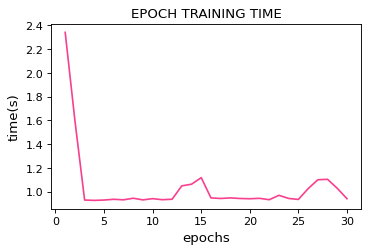

In [53]:
epochs = np.arange(1, N_EPOCHS + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, history.epoch_train_time, color="#F7418F")
plt.title("EPOCH TRAINING TIME", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("time(s)", fontsize=12)
plt.show()

Let's plot the model's training history in terms of acuracy over a period of `N_EPOCHS` epochs in our train and valid sets.

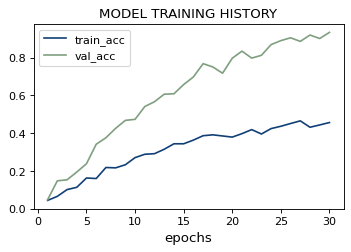

In [54]:
epochs = np.arange(1, N_EPOCHS + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, history.train_acc, label="train_acc", color="#124076")
plt.plot(epochs, history.val_acc, label="val_acc", color="#7F9F80")
plt.title("MODEL TRAINING HISTORY", color="k", fontsize=12)
plt.legend()
plt.xlabel("epochs", fontsize=12)
plt.show()

In the following code cell we are going to visualize the model training history interms of the validation loss and train loss in `N_EPOCHS`.

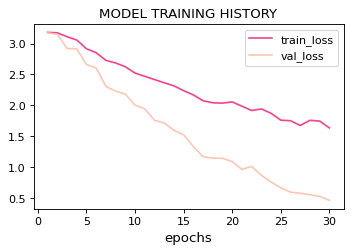

In [55]:
epochs = np.arange(1, N_EPOCHS + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, history.train_losses, label="train_loss", color="#F7418F")
plt.plot(epochs, history.val_losses, label="val_loss", color="#FEC7B4")
plt.title("MODEL TRAINING HISTORY", color="k", fontsize=12)
plt.legend()
plt.xlabel("epochs", fontsize=12)
plt.show()

### Evaluating the best model.
In the following code cell we are going to evaluate the best model using on the `test` data as follows:

In [56]:
column_names = ["Set", "Loss", "Accuracy", "ETA (time)"]
s2dc_model.load_state_dict(torch.load(MODEL_NAME))
test_loss, test_acc = evaluate(s2dc_model, test_loader, criterion)
title = "Model Evaluation Summary"
data_rows = [["Test", f'{test_loss:.3f}', f'{test_acc * 100:.2f}%', ""]]

tabulate_data(column_names, data_rows, title)

Model Evaluation Summary
+------+-------+----------+------------+
| Set  |  Loss | Accuracy | ETA (time) |
+------+-------+----------+------------+
| Test | 0.456 |   93.23% |            |
+------+-------+----------+------------+


We can also visualize the losses and accuracies of each model set.

1. train
2. test
3. validation

In [57]:
_test_loss, _test_acc = evaluate(s2dc_model, test_loader, criterion)
_train_loss, _train_acc = evaluate(s2dc_model, train_loader, criterion)
_valid_loss, _valid_acc = evaluate(s2dc_model, val_loader, criterion)

xs = np.array(['training', 'testing', 'validation'])
losses = np.array([train_loss, _test_loss, _valid_loss])
accuracies = np.array([train_acc * 100, _test_acc * 100, _valid_acc * 100])

Next we are going to `visualize` the model accuracies when it is evaluated using the:

1. train
2. test
3. validation

...data

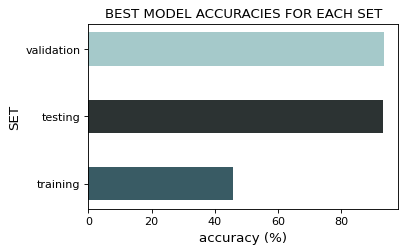

In [58]:
plt.figure(figsize=(5, 3), dpi=80)
plt.barh(xs, accuracies, label= xs, height=.5, color=['#395B64', '#2C3333', '#A5C9CA'], align="center")
plt.title("BEST MODEL ACCURACIES FOR EACH SET", color="k", fontsize=12)
plt.ylabel("SET", fontsize=12)
plt.xlabel("accuracy (%)", fontsize=12)
plt.show()

Next we are going to `visualize` the model losses when it is evaluated using the:

1. train
2. test
3. validation

...data

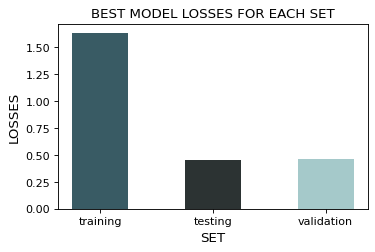

In [59]:
plt.figure(figsize=(5, 3), dpi=80)
plt.bar(xs, losses, label= xs, width=.5, color=['#395B64', '#2C3333', '#A5C9CA'], align="center")
plt.title("BEST MODEL LOSSES FOR EACH SET", color="k", fontsize=12)
plt.xlabel("SET", fontsize=12)
plt.ylabel("LOSSES", fontsize=12)
plt.show()

### Model Inference
In the following code cell we are going to make predictions with the best model. We will have the function called `inference_preprocess_text` which is a function that process the text for inference.

In [60]:
def inference_preprocess_text(text, max_len=100, padding="pre"):
  assert padding=="pre" or padding=="post", "the padding can be either pre or post"
  text_holder = torch.zeros(max_len, dtype=torch.int32) # fixed size tensor of max_len with  = 0
  processed_text = torch.tensor(text_pipeline(text), dtype=torch.int32)
  pos = min(max_len, len(processed_text))
  if padding == "pre":
    text_holder[:pos] = processed_text[:pos]
  else:
    text_holder[-pos:] = processed_text[-pos:]
  text_list= text_holder.unsqueeze(dim=0)
  return text_list

### Predicting Diseases
In the following code cell we are going to create a function that predicts the `diseases` given a certain `sickness symptoms` called `predict_disease`.

In [61]:
class Prediction:
  def __init__(self, pattern: str, disease: str, diseaseId: int, confidence: float):
    self.pattern = pattern
    self.disease = disease
    self.diseaseId = diseaseId
    self.confidence = confidence

  def __repr__(self) -> str:
    return f"<S2DC Preciction: {self.disease}>"

  def __str__(self) -> str:
    return f"<S2DC Preciction: {self.disease}>"

  def to_json(self):
    return {
        'pattern':  self.pattern,
        'disease':  self.disease,
        'diseaseId':  self.diseaseId,
        'confidence':  self.confidence,
    }

In [62]:
def predict_disease(model, sentence, device):
  model.eval()
  with torch.no_grad():
    tensor = inference_preprocess_text(sentence.lower()).to(device)
    length = torch.tensor([len(t) for t in tensor])
    probabilities = torch.softmax(model(tensor, length).squeeze(0), dim=0)
    prediction = torch.argmax(probabilities)
    prediction = prediction.detach().cpu().item()
    tags = {v:k for k, v in labels_dict.items()}
    tag = tags[prediction]

    return Prediction(
        sentence.lower(), tag, int(prediction), float(round(probabilities[prediction].item(), 2))
    )

In [63]:
pneumonia =predict_disease(s2dc_model, "i've recently been suffering with chills, lethargy, a cough, a high temperature, and difficulties breathing. i've been sweating profusely and generally feeling ill and weak. i've also had some quite thick and red phlegm.", device)
pneumonia

<S2DC Preciction: pneumonia>

Using the `.to_json()` method we are going to get the following data.

In [64]:
pneumonia.to_json()

{'pattern': "i've recently been suffering with chills, lethargy, a cough, a high temperature, and difficulties breathing. i've been sweating profusely and generally feeling ill and weak. i've also had some quite thick and red phlegm.",
 'disease': 'pneumonia',
 'diseaseId': 8,
 'confidence': 0.72}

### Downloading the model.
We are going to download the model

In [65]:
files.download(MODEL_NAME)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Model evaluation
In this section we are going to evaluate the best model and visualize the matrics. We are going to use the following evaluation methods on this classification task.

1. `confusion matrix`
2. `classification report`

First of all we need to get the actual values and predicted values from the `test_loader` so that we will be able to use all the examples in the test dataset to evaluate our model. We are going to define a function called `get_predictions` this function will take in the `model`, `loader` and `device` as parameter and return the following lists of values:

1. `labels` - the actual image label
2. `probs` - the list of probabilities for the text to belong to a certain class.

In [66]:
def get_predictions(model, iterator, device):
  model.eval()
  labels = []
  probs = []
  with torch.no_grad():
    for batch in iterator:
      y, X = batch
      X = X.to(device)
      lengths = torch.tensor([len(i) for i in X])
      predictions = model(X, lengths).squeeze(1)
      labels.append(y)
      probs.append(predictions)

  labels = torch.cat(labels, dim = 0)
  probs = torch.softmax(torch.cat(probs, dim = 0), dim=1)
  return labels, probs

Let's go ahead and get the `real_labels` and `probabilities` from the `test_loader` using our `get_predictions` function.

In [67]:
true_labels, probs = get_predictions(s2dc_model, test_loader, device)
assert len(true_labels) == len(probs), "The predicted and real labels must have the same shape."

The `probs` are not the predicted labels, it is a torch tensor of size `24` elements in it.

To get the predicted values from the text in the `test_set` we need to use the `torch.argmax()` function which returns us the index with the highest number in a torch tensor. We are going to calculate the argmax of our probability in the first dimenion to get all the predicted values labels as follows:

In [68]:
predicted_labels = torch.argmax(probs, dim=1)

### The confusion matrix
Let's create a confusion matrix as a way of visualizing how good our model is when it comes to predicting text in the test dataset. We are going to use a function called `plot_complicated_confusion_matrix` from `helperfns.visualization` in the following code cell.

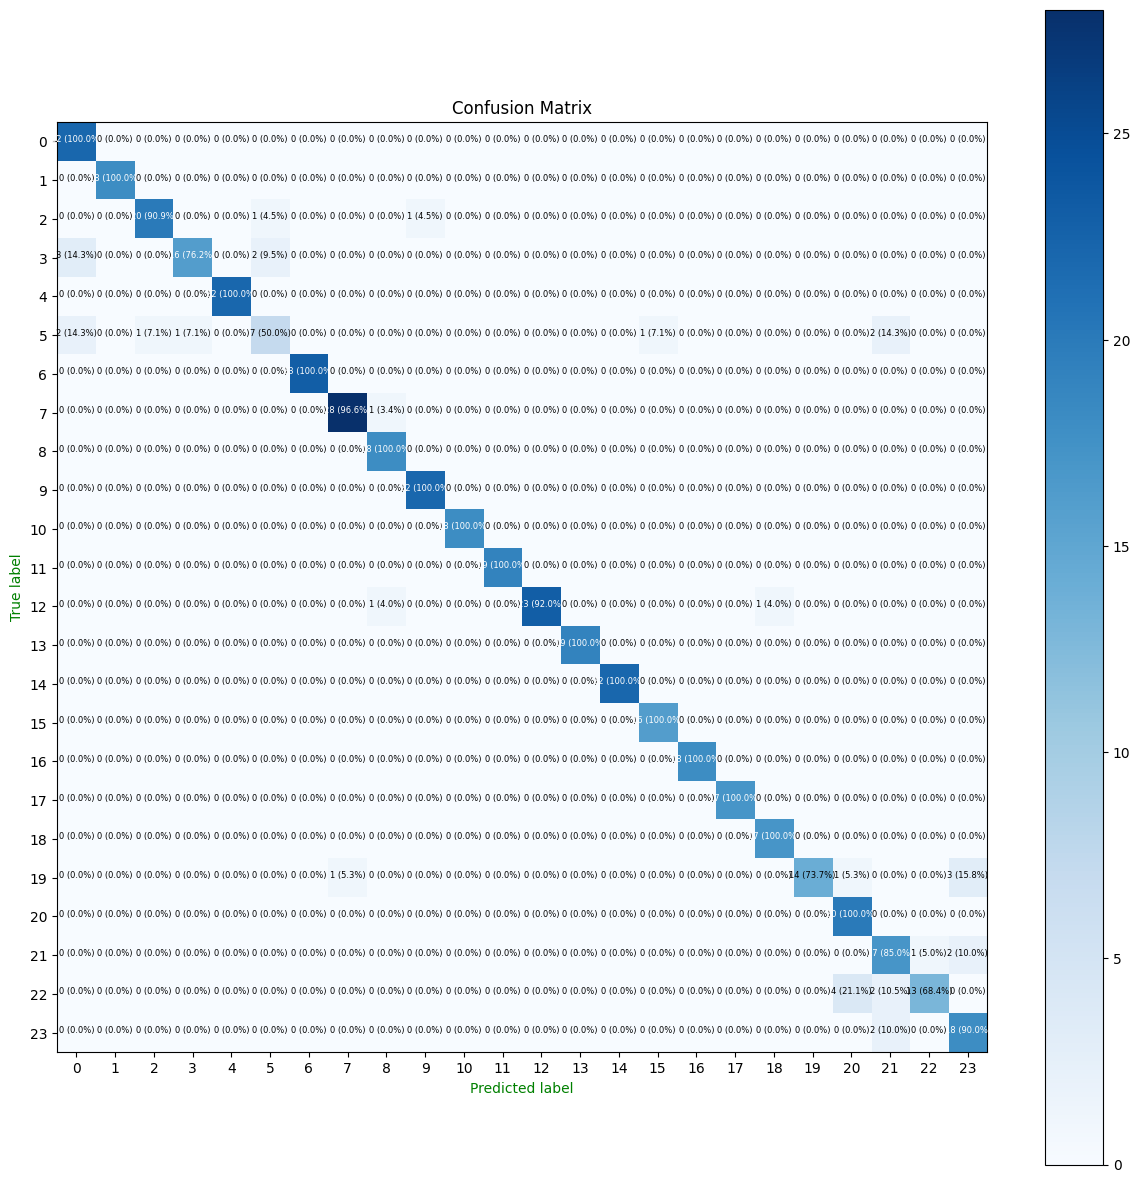

In [69]:
plot_complicated_confusion_matrix(
    true_labels,
    predicted_labels.detach().cpu(),
    labels_dict.values(),
     fontsize=6,
    figsize=(15, 15)
)

### Classification report
In the following code cell we are going to print the classification report as a way of measuring how good our model was in predicting (normal, pneumonia-virus and pneumonia-bacteria).

In [70]:
from sklearn.metrics import classification_report
cr = classification_report(true_labels, predicted_labels.detach().cpu(), output_dict=False)
print(cr)

              precision    recall  f1-score   support

           0       0.81      1.00      0.90        22
           1       1.00      1.00      1.00        18
           2       0.95      0.91      0.93        22
           3       0.94      0.76      0.84        21
           4       1.00      1.00      1.00        22
           5       0.70      0.50      0.58        14
           6       1.00      1.00      1.00        23
           7       0.97      0.97      0.97        29
           8       0.90      1.00      0.95        18
           9       0.96      1.00      0.98        22
          10       1.00      1.00      1.00        18
          11       1.00      1.00      1.00        19
          12       1.00      0.92      0.96        25
          13       1.00      1.00      1.00        19
          14       1.00      1.00      1.00        22
          15       0.94      1.00      0.97        16
          16       1.00      1.00      1.00        18
          17       1.00    